# SHRED for Parametric MSFR-ULOFF: outcore flux measures
This notebook implements the SHRED architecture for generating a parametric Reduced Order Model (ROM) of the Molten Salt Fast Reactor (MSFR) during an accidental scenario named ULOFF (Unprotected Loss of Fuel Flow).

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

path_snaps = '../../NuSHRED_Datasets/D2/'
path_svd = 'OfflineSVD/'
idx_params, params, var_names, is_vector, fom_times, rescaling_snaps, Nmodes = pickle.load(open(path_svd+'msfr_p.uloff', 'rb'))

## Compute Measures
The SHRED architecture takes as input 3 sensor measures and maps them to the reduced space characterizing the MSFR-ULOFF scenario. The sensor are placed outside the core and measure the total flux $\Phi$
\begin{equation*}
y^\Phi_m = v_m (\Phi)\cdot(1+ \epsilon_m), \quad m = 1, 2, 3
\end{equation*}
where $v_m$ is a functional describing the sensor procedure (either point-wise or Gaussian averaged) and $\epsilon_m$ is a Gaussian noise with standard deviation $\sigma$.

Let us import the snapshots at first.

In [2]:
measured_field = 3

# Import Snaps - in compression format
u_data  = pickle.load(open(path_snaps + f'CompressedDataset/pod_basis_{var_names[measured_field]}.svd', 'rb'))
s_data  = pickle.load(open(path_snaps + f'CompressedDataset/sing_vals_{var_names[measured_field]}.svd', 'rb'))
vh_data = pickle.load(open(path_snaps + f'CompressedDataset/v_POD_all_fields.svd', 'rb'))[var_names[measured_field]]

measured_snaps = dict()
for key in idx_params.keys():
    measured_snaps[key] = np.asarray([ (u_data @ s_data @ vh_data[ii].T).T 
                                      for ii in idx_params[key]])

del u_data, s_data, vh_data # free memory

Let us load the mesh

In [3]:
nodes = pickle.load(open(path_snaps+'domain.pkl', 'rb'))

Let us select the cells where the sensors can be placed

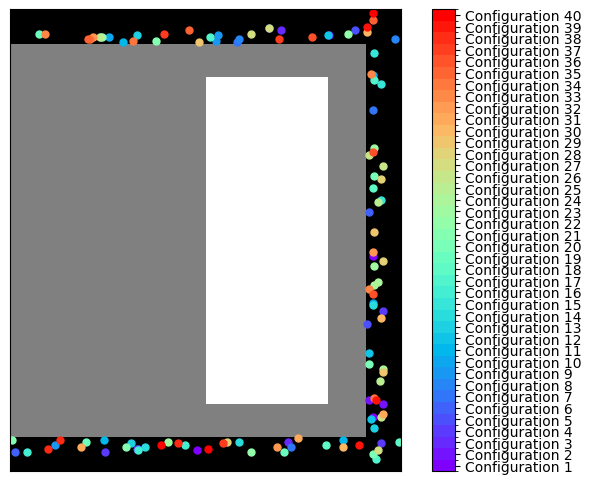

In [4]:
def is_out_core(node):
    return ((node[1] <= -1.13 and node[1] >= -1.23) or 
            (node[1] >=  1.13 and node[1] <=  1.23)) or (node[0] >= 2.05 and node[0] <= 2.15)

out_core = np.array([is_out_core(node) for node in nodes])
out_core_idx = np.where(out_core)[0]
in_core_idx  = np.where(~out_core)[0]

# Sampling the sensors locations
num_sensors = 3

n_configurations = 40
idx_sensor_locations = np.zeros((num_sensors, n_configurations), dtype=int)

np.random.seed(1) # set seed for reproducibility
for kk in range(n_configurations):
    idx_sensor_locations[:, kk] = np.asarray(np.random.choice(out_core_idx, size=num_sensors, replace=False), dtype=int)

# Plotting the sensors locations
from plots import get_msfr_geometry
import matplotlib.colors as mcolors

fig, axs = plt.subplots(figsize=(8,6))
get_msfr_geometry(axs)

cmap = cm.rainbow
colors = cmap(np.linspace(0,1,n_configurations))
for kk in range(n_configurations):
    axs.scatter(nodes[idx_sensor_locations[:, kk], 0], nodes[idx_sensor_locations[:, kk], 1], 
                color = colors[kk], s=25, label=f'Configuration {kk+1}')

# Create a discrete colormap and normalization
bounds = np.linspace(1, n_configurations+1, n_configurations+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add the discrete colorbar to the plot
midpoints = (bounds[:-1] + bounds[1:]) / 2
cbar = plt.colorbar(sm, ax=axs, ticks=np.arange(n_configurations + 1))
cbar.ax.set_yticks(midpoints)
cbar.ax.set_yticklabels([f'Configuration {i}' for i in np.hstack([np.array([1]), np.arange(2, n_configurations + 1, 1, dtype=int)])])

plt.show()

Let us now extract the sensor measures from the snapshots

In [5]:
snap_measurements = list()

for kk in range(n_configurations):

    snap_measurements.append({
        key: measured_snaps[key][:, :, idx_sensor_locations[:,kk]]
        for key in list(measured_snaps.keys())
    })

del measured_snaps

Let us add uncorrelated Gaussian noise to the measures

In [6]:
noise_value = 0.025
Xsensor = list()

for kk in range(n_configurations):
    Xsensor.append({
        key: snap_measurements[kk][key] * (1+np.random.normal(scale=noise_value, size=snap_measurements[kk][key].shape))
        for key in list(snap_measurements[kk].keys())
    })


print('Sensors Shape')
print(Xsensor[0]['train'].shape)
print(Xsensor[0]['test'].shape)
print(Xsensor[0]['valid'].shape)

Sensors Shape
(15, 600, 3)
(3, 600, 3)
(3, 600, 3)


Let us scale them to be in the range $[0, 1]$

In [7]:
from sklearn.preprocessing import MinMaxScaler

rescaled_Xsensor = list()
sens_scaler = list()
for kk in range(n_configurations):
    sens_scaler.append(MinMaxScaler())
    sens_scaler[kk].fit(Xsensor[kk]['train'].reshape(-1, num_sensors))

    rescaled_Xsensor.append({
        key: sens_scaler[kk].transform(Xsensor[kk][key].reshape(-1, num_sensors)).reshape(Xsensor[kk][key].shape)
        for key in list(Xsensor[kk].keys())
    })

Plotting some measures for a trajectory of the training set

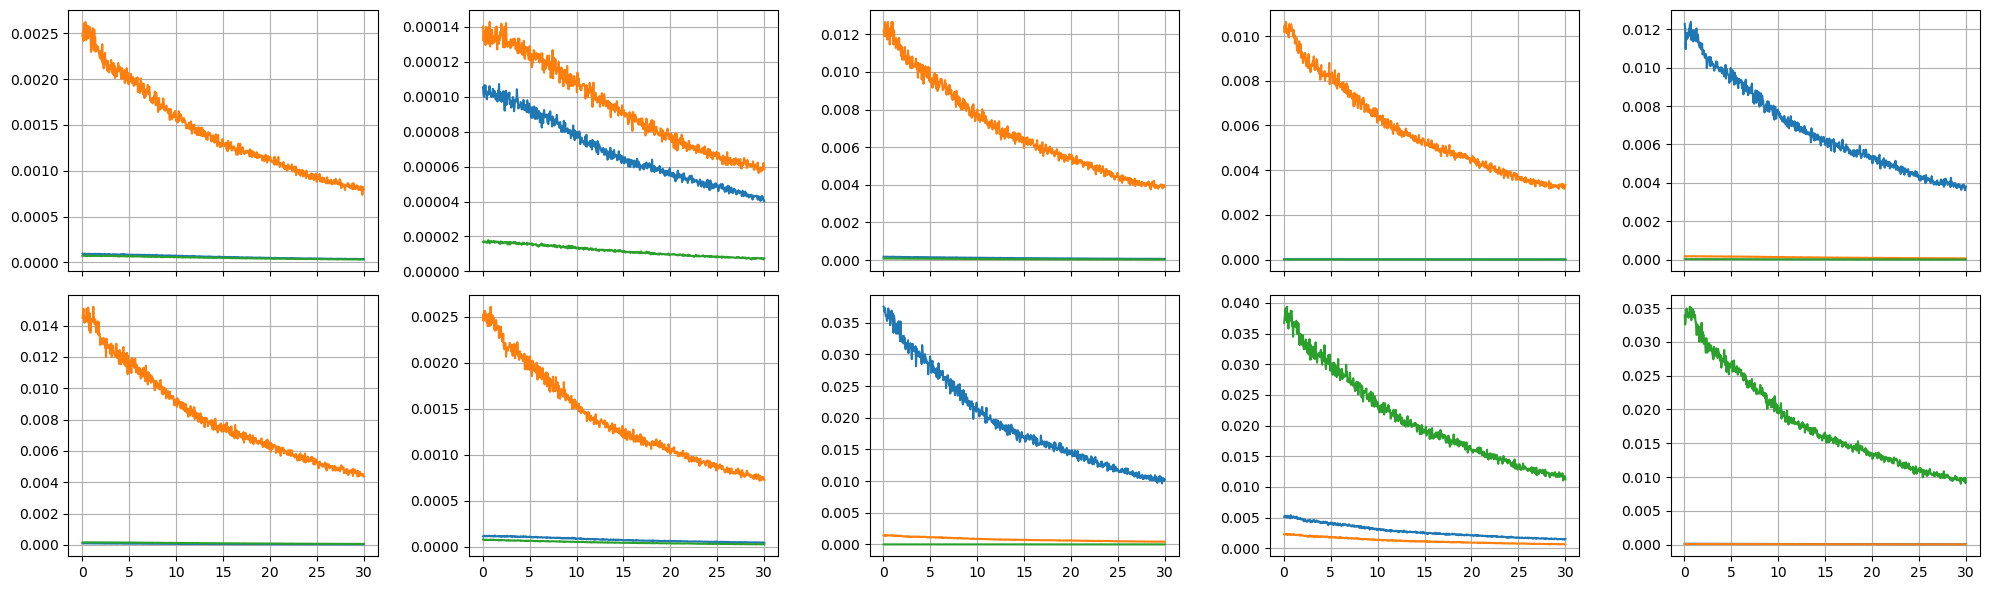

In [8]:
ncols = 5
nrows = 2
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, figsize= (4 * ncols, 3 * nrows))
axs = axs.flatten()

param_to_plot = 3

for kk in range(nrows * ncols):
    axs[kk].plot(fom_times, Xsensor[kk]['train'][param_to_plot])
    axs[kk].grid()
    
plt.tight_layout()

## Padding
In this section, the data are prepared to be fed into the SHRED architecture.

At first, let us load the POD coefficients and let us rescale them between 0 and 1.

In [9]:
v_POD = pickle.load(open(path_svd+'v_POD.svd', 'rb'))

assert sum(Nmodes) == v_POD['train'].shape[2]

vpod_scaler = MinMaxScaler()
vpod_scaler.fit(v_POD['train'].reshape(-1, sum(Nmodes)))

rescaled_v_POD = {
    key: vpod_scaler.transform(v_POD[key].reshape(-1, sum(Nmodes))).reshape(v_POD[key].shape)
    for key in list(v_POD.keys())
}

Let us create the parameters data

In [10]:
mu = np.zeros((params.shape[0], len(fom_times), params.shape[1]))
for idx in range(params.shape[0]):
    mu[idx] = params[idx]

parameters = {
    key : mu[idx_params[key]]
    for key in list(idx_params.keys())
}

Nparams = params.shape[1]
param_scaler = MinMaxScaler()
param_scaler.fit(parameters['train'].reshape(-1, Nparams))

rescaled_parameters = {
    key: param_scaler.transform(parameters[key].reshape(-1, Nparams)).reshape(parameters[key].shape)
    for key in list(parameters.keys())
}

print('Params Shape')
print(rescaled_parameters['train'].shape)
print(rescaled_parameters['test'].shape)
print(rescaled_parameters['valid'].shape)

print('POD Coeff Shape')
print(rescaled_v_POD['train'].shape)
print(rescaled_v_POD['test'].shape)
print(rescaled_v_POD['valid'].shape)

Params Shape
(15, 600, 1)
(3, 600, 1)
(3, 600, 1)
POD Coeff Shape
(15, 600, 220)
(3, 600, 220)
(3, 600, 220)


Then, let us prepare them for the SHRED architecture

In [11]:
import sys
sys.path.append('../../')

from shred.processdata import Padding, TimeSeriesDataset
import torch

# GPU
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')

lags = 20

# Input Data
train_data_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['train']), lags).to(device) for kk in range(n_configurations)]
valid_data_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['valid']), lags).to(device) for kk in range(n_configurations)]
test_data_in  = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['test']), lags).to(device)  for kk in range(n_configurations)]

# Output Data
train_data_out = [Padding(torch.cat((torch.from_numpy(rescaled_v_POD['train']), 
                                     torch.from_numpy(rescaled_parameters['train'])), 
                                     axis=2), 1).squeeze(1).to(device)
                                     for kk in range(n_configurations)]

valid_data_out = [Padding(torch.cat((torch.from_numpy(rescaled_v_POD['valid']), 
                                     torch.from_numpy(rescaled_parameters['valid'])), 
                                     axis=2), 1).squeeze(1).to(device)
                                     for kk in range(n_configurations)]

test_data_out = Padding(torch.cat((torch.from_numpy(rescaled_v_POD['test']), 
                                     torch.from_numpy(rescaled_parameters['test'])), 
                                     axis=2), 1).squeeze(1).to(device)

# Create Dataset for SHRED training
train_dataset = [TimeSeriesDataset(train_data_in[kk], train_data_out[kk]) for kk in range(n_configurations)]
valid_dataset = [TimeSeriesDataset(valid_data_in[kk], valid_data_out[kk]) for kk in range(n_configurations)]
test_dataset  = [TimeSeriesDataset(test_data_in[kk],  test_data_out)  for kk in range(n_configurations)]


## SHRED
Let us train the SHRED models for each configuration

In [12]:
from shred.models import SHRED, fit
import os

path_shred = './SHRED/EnsembleSensitivity/'
os.makedirs(path_shred, exist_ok=True)

train_net = False

shred = list()
for kk in range(n_configurations):
    
    shred.append(SHRED( num_sensors, sum(Nmodes) + Nparams, 
                        hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device))

    if train_net:
        print('Training SHRED - configuration '+str(kk+1)+'/'+str(n_configurations))

        fitting_errors = fit(   shred[kk], train_dataset[kk], valid_dataset[kk], 
                                batch_size = 64, epochs = 600, lr = 1e-3, verbose = True, patience = 30)

        torch.save(shred[kk].state_dict(), path_shred+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'sens_'+var_names[measured_field]+'.shred')
        print(' ')
    else:
        shred[kk].load_state_dict(torch.load(path_shred+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'sens_'+var_names[measured_field]+'.shred',
                                             map_location=device))
    

Checking the test errors on the POD coefficients

In [118]:
from shred.processdata import num2p, mre

[_shred.freeze() for _shred in shred]

Ytest_POD_hat = torch.stack([shred[kk](test_data_in[kk]) for kk in range(n_configurations)], dim=0)

Ytest_POD_pred = {
    'mean': list(),
    'std':  list()
}

for kk in range(1, n_configurations):
    _mean = 1/(kk+1) * (Ytest_POD_hat[:kk+1].sum(axis=0))
    _var  = 1/(kk) * sum([(Ytest_POD_hat[ll] - _mean).pow(2) for ll in range(kk+1)])
    
    Ytest_POD_pred['mean'].append(_mean)
    Ytest_POD_pred['std'].append(torch.sqrt(_var) / np.sqrt(kk+1))

Ytest_POD_pred['mean_formula'] = [Ytest_POD_hat[:kk].mean(axis=0) for kk in range(1, n_configurations)]
Ytest_POD_pred['std_formula']  = [Ytest_POD_hat[:kk].std(axis=0) for kk in range(1, n_configurations)]

Let us plot how the variance of the mean estimator reduces with the number of configurations

Text(0, 0.5, 'Standard Deviation $\\xi_L$')

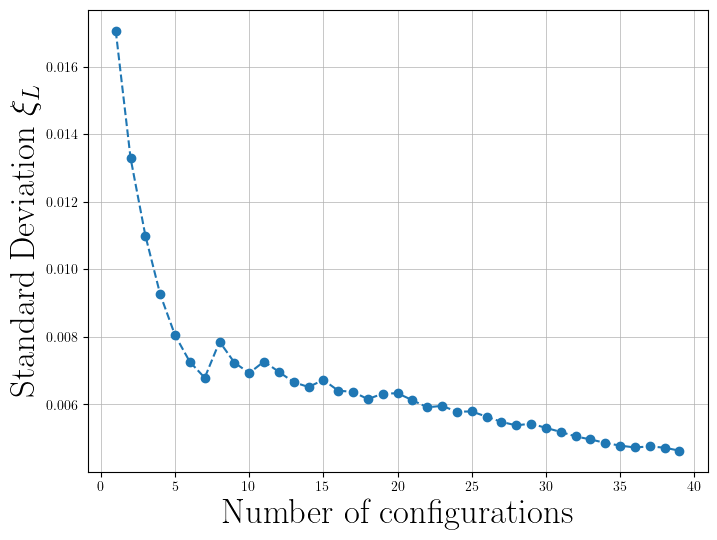

In [132]:
from matplotlib import rcParams
rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

rcParams['text.latex.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{amsthm} \usepackage{mathtools}'

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axs.plot(np.arange(1, len(Ytest_POD_pred['std'])+1,1), [Ytest_POD_pred['std'][ll].mean().cpu().detach().numpy() for ll in range(len(Ytest_POD_pred['std']))], 'o--')

axs.grid(which='minor', linestyle=':', linewidth=0.5)
axs.grid(which='major', linestyle='-', linewidth=0.5)

axs.set_xlabel('Number of configurations', fontsize=25)
axs.set_ylabel(r'Standard Deviation $\xi_L$', fontsize=25)

Let us make a pandas dataframe with the results of the sensitivity analysis

In [145]:
import pandas as pd

df = pd.DataFrame({
    'Number of configurations': np.arange(1, len(Ytest_POD_pred['std'])+1,1),
    r'Standard Deviation $\xi_L$': [Ytest_POD_pred['std'][ll].mean().cpu().detach().numpy() for ll in range(len(Ytest_POD_pred['std']))],
    r'Normalized Standard Deviation $\xi_L/\xi_L^{\mathrm{max}}$': [Ytest_POD_pred['std'][ll].mean().cpu().detach().numpy()/Ytest_POD_pred['std'][0].mean().cpu().detach().numpy() for ll in range(len(Ytest_POD_pred['std']))]
})

df

,Number of configurations,Standard Deviation $\xi_L$,Normalized Standard Deviation $\xi_L/\xi_L^{\mathrm{max}}$
0,1,0.017065926,1.000000
1,2,0.013294526,0.779010
2,3,0.010995701,0.644307
3,4,0.009255966,0.542365
4,5,0.008047244,0.471539
5,6,0.007257445,0.425259
6,7,0.006788753,0.397796
7,8,0.007857417,0.460416
8,9,0.0072389315,0.424175
9,10,0.006928554,0.405988


Let us plot the error up to configuration $k$.

Text(0, 0.5, 'Std. Dev. $\\sigma_k$')

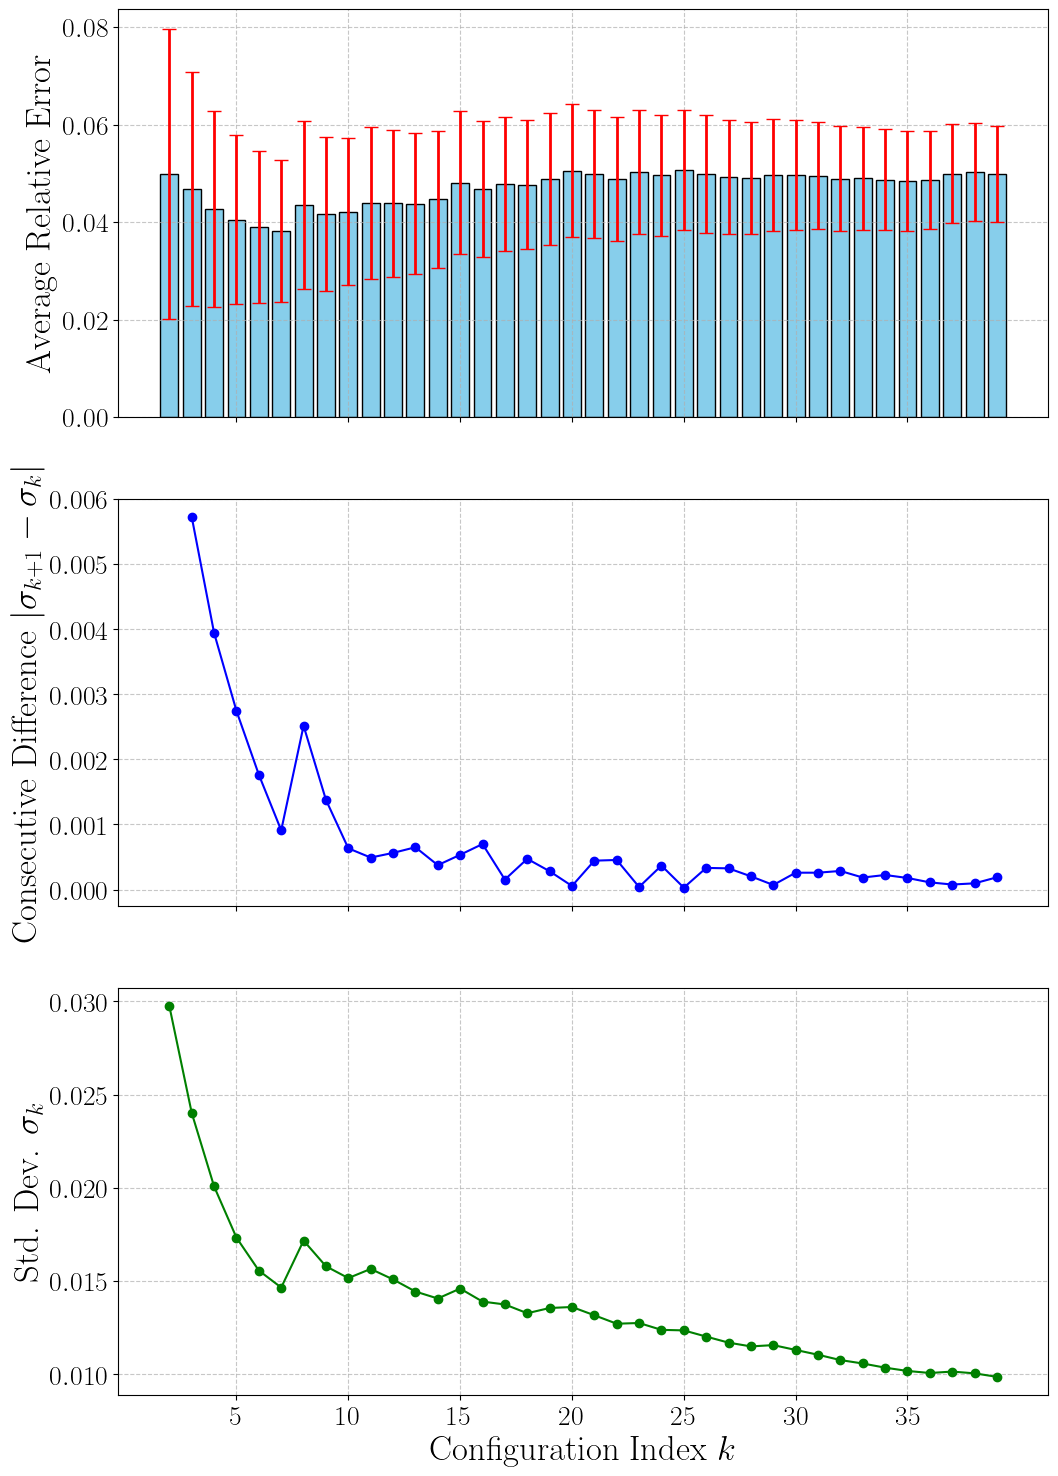

In [117]:
mean_ave = [mre(test_data_out, mean).cpu().detach().numpy() for mean in Ytest_POD_pred['mean'][1:]]
std_ave = [(std.pow(2).sum(axis = -1).sqrt() / (test_data_out).pow(2).sum(axis = -1).sqrt()).mean().cpu().detach().numpy() for kk, std in enumerate(Ytest_POD_pred['std'][1:])]

fig, axs = plt.subplots(nrows = 3, ncols=1, figsize=(12, 18), sharex=True)

# Plotting the mean and standard deviation
ax = axs[0]
mean_ave_np = np.array(mean_ave)
std_ave_np = np.array(std_ave)

x = np.arange(len(mean_ave_np))+2
ax.bar(x, mean_ave_np, yerr=std_ave_np, capsize=5, color='skyblue', edgecolor='black', error_kw={'elinewidth': 2, 'ecolor': 'red'})

# Consecutive decrease of the mean
ax = axs[1]
ax.plot(x[1:], np.abs(np.diff(std_ave_np)), marker='o', color='blue', label='Mean')

# Decrease of the std deviation 
ax = axs[2]
ax.plot(x, std_ave_np, marker='o', color='green', label='Standard Deviation')

for ax in axs:
    ax.set_xticks(x[3::5])
    ax.grid(linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=20)

axs[-1].set_xlabel('Configuration Index $k$', fontsize=25)
axs[0].set_ylabel('Average Relative Error', fontsize=25)
axs[1].set_ylabel(r'Consecutive Difference $|\sigma_{k+1}-\sigma_{k}|$', fontsize=25)
axs[2].set_ylabel(r'Std. Dev. $\sigma_k$', fontsize=25)